# CSI 6160 Homework 3
### Samantha Bracellari & Justin Kur

For this assignment, we used a dataset with 512 samples, each with 13 features, that described "per 
capita crime rate by town". The dataset can be found here: 
https://www.kaggle.com/code/vijaykumar1799/crime-rate-prediction-linear-regression/data.

We do a bit of preprocessing on the data; first, normalizing it by min-max scaling every column, 
filled any missing values with the respective column's median (after scaling), and finish by 
performing 5-fold cross validation and splitting the data into train and test sets. 80% of the data 
will be used for training, while the remaining 20% will be used for testing.

In [1]:
import polars as pl
from sklearn.model_selection import KFold
import numpy as np

def fetch_data(df, use_split, rbf=False):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    rm_median = df_train.get_column("RM").median()
    df_train = df_train.with_columns(pl.col('RM').fill_null(rm_median))
    df_test = df_test.with_columns(pl.col('RM').fill_null(rm_median))
    for col in df_train.columns:
        if col == "CRIM":
            df_train, df_test = scale_column(df_train, df_test, col) # normalize
            continue
        if rbf:
            df_train, df_test = rbf_column(df_train, df_test, col) # Use radial bias function
        else:
            df_train, df_test = scale_column(df_train, df_test, col) # normalize
    return df_train, df_test

# perform min-max scaling
def scale_column(df_train, df_test, col_name):
    max = df_train.get_column(col_name).max()
    min = df_train.get_column(col_name).min()
    df_train = df_train.with_columns((pl.col(col_name) - min) / (max - min))
    df_test = df_test.with_columns((pl.col(col_name) - min) / (max - min))
    return df_train, df_test

def rbf_column(df_train, df_test, col_name):
    std = df_train.get_column(col_name).std()
    low = df_train.get_column(col_name).quantile(0.25)
    middle = df_train.get_column(col_name).quantile(0.5)
    high = df_train.get_column(col_name).quantile(0.75)
    for i, val in enumerate([low, middle, high]):
        df_train = df_train.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        df_test = df_test.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        # f = lambda x, c: math.exp(-1.0 * (x - c)**2 / (2 * std)**2)
    return df_train.drop(col_name), df_test.drop(col_name)

# fill empty spaces with median
def get_x_y(df):
    X, y = df.drop('CRIM'), df.get_column('CRIM')
    # X = X.with_columns(pl.col('RM').fill_null(pl.median('RM'))) # column 'RM' had some missing values
    X = X.with_columns(pl.lit(1.0).alias('CONSTANT')) # extra column for the bias term
    return X.to_numpy(), y.to_numpy()

f_name = 'crime.csv'
df = pl.read_csv(f_name, has_header=True, sep=',') # comma separated data
df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000462,0.0,0.404071,0.0,0.381743,0.473079,0.795309,0.125072,0.0,0.164122,0.807692,1.0,0.082806,0.11129
0.01103,0.0,0.425556,0.0,0.356846,0.655106,0.882729,0.088061,0.086957,0.253817,1.0,0.997731,0.138279,0.112903
0.004923,0.0,0.425556,0.0,0.356846,0.490899,0.978678,0.168902,0.086957,0.253817,1.0,0.864088,0.259459,0.790323
0.008669,0.0,0.433095,0.0,0.356846,0.509868,0.296375,0.128527,0.086957,0.270992,1.0,0.864088,1.0,1.0
0.007283,0.0,0.436864,0.0,0.356846,0.612953,0.648188,0.168902,0.086957,0.301527,1.0,0.808614,0.582604,0.306452


## Grid Search

The next step was to perform a grid search on the lambda value to determine the best weights
possible for the model. We generated logarithmically spaced values between (-5,5) to test with, and kept 
track of the resulting weights for each. The weights themselves were calculated using the 
Moore-Penrose inverse matrix method.

In [2]:
l = np.logspace(-5, 5) # lambda values to test

def linear_regression(X, y, lambdas):
    weights = []
    phi = X
    I = np.eye(X.shape[1])
    for l in lambdas:
        # calculate pseudo inverse matrix
        inside_part = np.linalg.inv(l*I + np.matmul(phi.T, phi))
        w = np.matmul(np.matmul(inside_part, phi.T), y)
        weights.append(w)
    return weights

weights = linear_regression(X_train, y_train, l)

## Experimenting & Benchmarking

To measure the accuracy of our model, we use the correlation coefficient ($R^2$) to determine how 
precisely the model was able to predict weights that achieved a value closest to the target when 
used with the linear model. We ran the model against the train sets to collect all of the potential 
weight vectors, and then used those weight vectors with the test sets to calculate the $R^2$ value.

As we usually do, we also benchmarked against Sci-Kit Learn's linear model with a Ridge (or L2) 
regularization.

In [3]:
from sklearn import linear_model

# calculating the R^2 score
def score(X, y, w):
    preds = np.array([np.dot(x, w) for x in X])
    u = ((y - preds)**2).sum()
    v = ((y - y.mean())**2).sum()
    r2 = 1 - (u/v)
    return r2

def run_experiment(df, use_split, lambdas, rbf=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    all_weights = linear_regression(X_train, y_train, lambdas)
    scores = [score(X_test, y_test, w).item() for w in all_weights]
    return np.array(scores)

def sk_bench(df, use_split, rbf=False):
    df_train, df_test = fetch_data(df, use_split, rbf=rbf)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    reg = linear_model.Ridge(alpha = 0.5, solver='cholesky')
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

## Experimental Results

We found that the best $R^2$ value achieved with our model overall was 0.48, which was about on par 
with sklearn. The lambda value that was used to achieve this score was 1.265.

In [4]:
out = np.stack([run_experiment(df, x, l, rbf=False) for x in range(5)])

print(f'Best: {out.mean(axis=0).argmax()}')
print(f'Best Score: {out.mean(axis=0).max()}')
print(f'Lambda Value: {l[25]}') 

Best: 25
Best Score: 0.48627620293745666
Lambda Value: 1.2648552168552958


## Cross Validation Test

On the left graph we can quantitatively inspect the effects of the lambda value on the weights decay. We see the optimally chosen lambda value (indicated by the blue line) shows a point where the weights have decayed slightly to prevent overfitting, but they have not decayed so much that they lose their predictive ability.  

On the right graph below we see that our method was superior in 3 trials and equivalent in the 
remaining two, although the differences are minor in every trial (aside from trial 2, where there 
our method had a clear advantage). Since we're seeing similar performance between our model and 
sklearn's, this validates our approach.

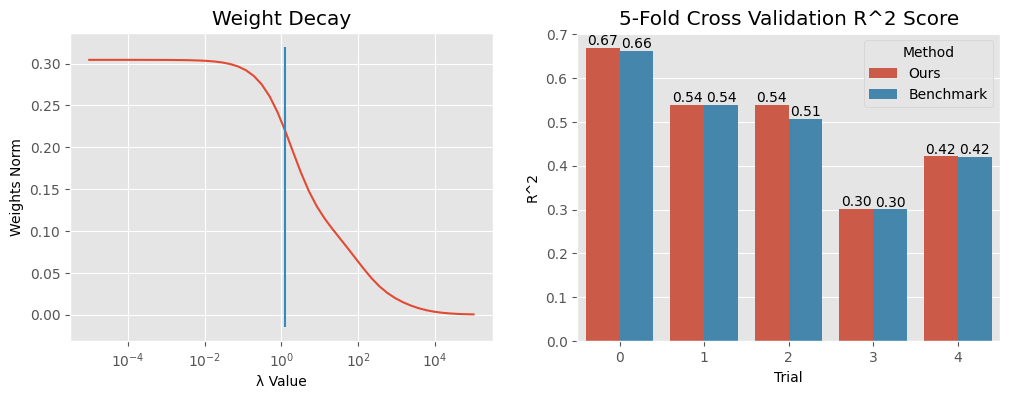

In [5]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')

out = np.stack([run_experiment(df, x, l, rbf=False) for x in range(5)])

COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(l, [np.linalg.norm(x) for x in weights], color=COLORS[0])
ax[0].vlines(l[out.mean(axis=0).argmax()], ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1], color=COLORS[1])
ax[0].set_xscale('log')
ax[0].set_ylabel('Weights Norm')
ax[0].set_xlabel('λ Value')
ax[0].set_title('Weight Decay')

our_method = out.max(axis=1).tolist()
benchmark = [sk_bench(df, x, rbf=False) for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'R^2': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax[1].set_title('5-Fold Cross Validation R^2 Score')
seaborn.barplot(data=plot_df, x='Trial', y='R^2', hue='Method', ax=ax[1], palette=COLORS)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.2f")

### Radial Basis Function

To try to improve our model's predictions, we implement a gaussian radial basis function on each of the predictive features. We replace each feature with three new features, with the centers set at the 25th, 50th, and 75th percentiles. We find that this increases performance for both our method and sklearn, with only one instance where $R^2$ decreased by 0.01, while it increased in all other cases. In some cases this improvement was significant, particularly in Trial 1 where our method improved from 0.54 to 0.66 and Trial 3 where it improved from 0.30 to 0.37. We see in this case our method has a greater advantage over sklearn, implying that the selection of the optimal lambda value is more important in this case. Because we select the best lambda observed in each trial, we expect that our method should outperform sklearn.

Using this basis function allows us to keep using the simple, interpretable linear model while allowing it to make predictions beyond linear combinations of the input features.

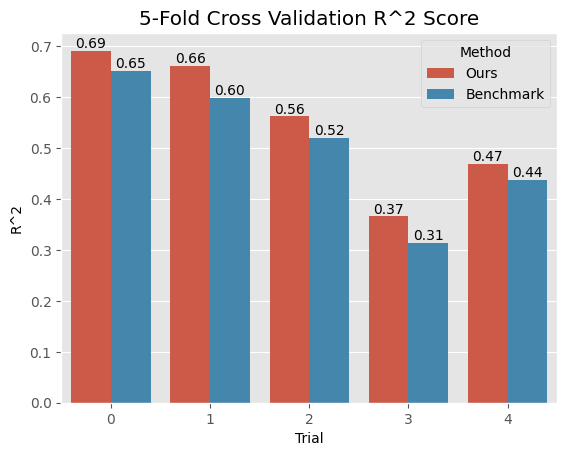

In [6]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')

out = np.stack([run_experiment(df, x, l, rbf=True) for x in range(5)])

COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 1)

our_method = out.max(axis=1).tolist()
benchmark = [sk_bench(df, x, rbf=True) for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'R^2': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation R^2 Score')
seaborn.barplot(data=plot_df, x='Trial', y='R^2', hue='Method', ax=ax, palette=COLORS)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")